In [4]:
import numpy as np
import pandas as pd

import os
import shutil
import io
import json
import zipfile
import cv2
from PIL import Image, ImageDraw

from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
mpl.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"]=False

# 1. TRAIN DATA Pre-Processing

## 1.1. TEST DATA
> IMG/LABEL 확인

In [5]:
TRAIN_IMG_PATH=r"../../data/raw/training/image_data/"
TRAIN_LABEL_PATH=r"../../data/raw/training/labeling_data/"

VAL_IMG_PATH=r"../../data/raw/validation/image_data/"
VAL_LABEL_PATH=r"../../data/raw/validation/labeling_data/"

In [7]:
# test용 jpg
TEST_IMG_PATH = TRAIN_IMG_PATH + r"F0001_IND_D_18_0_01.JPG"

img_color = cv2.imread(TEST_IMG_PATH, cv2.IMREAD_COLOR)
#plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
#plt.show()

In [8]:
# test용 label
TEST_LABEL_PATH = TRAIN_LABEL_PATH + r"F0001_IND_D_18_0_01.json"

with open(TEST_LABEL_PATH, "r") as f:
    json_data = json.load(f)
#json_data

# personal_id: D(Daughter) -> 성별(Female)
# age: 18 -> 10대(10s)
# keypoint: 중심점
# boundingbox: 바운딩 박스

Text(0.5, 1.0, '구분: D / 나이: 18세')

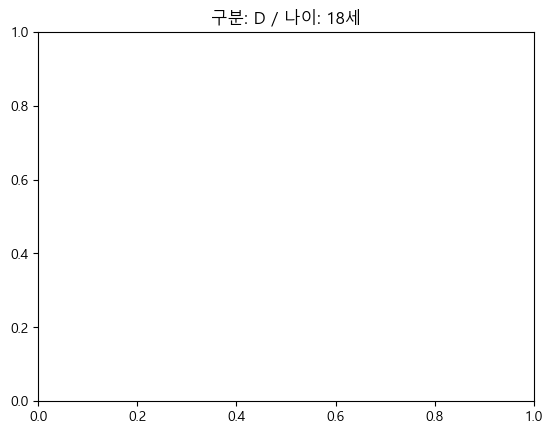

In [9]:
# test img 파일에 json 파일 첨가

# ========================================

# PIL 이용
# from PIL import Image, ImageDraw
img=Image.open(TEST_IMG_PATH).convert("RGB")
draw=ImageDraw.Draw(img)

# member -> regions -> keypoint/boundingbox
member=json_data["member"][0]
regions=member["regions"]

# 1. keypoint(중심점)
for keypoint in regions[0]["keypoint"]:
    x, y=int(keypoint["x"]), int(keypoint["y"])
    r=3
    draw.ellipse((x-r, y-r, x+r, y+r), fill="red")

# 2. bounding box
for b_box in regions[0]["boundingbox"]:
    x, y, w, h=int(b_box["x"]), int(b_box["y"]), int(b_box["w"]), int(b_box["h"])
    if b_box["idx"] == "0":  # 얼굴 bounding box만 세로부분 늘리기 (위만, 아래는 그대로)
        pad_y=100
        new_y=max(y-pad_y, 0)
        new_h=h+(y-new_y)
        draw.rectangle((x, new_y, x+w, new_y+new_h), outline="blue", width=2)
    else:  # 나머지는 그대로
        draw.rectangle((x, y, x+w, y+h), outline="blue", width=2)

# 3. 시각화
plt.title(f"구분: {member['personal_id']} / 나이: {member['age']}세")
#plt.imshow(img)
#plt.show()

## 1.2. ZIP FILES

In [ ]:
ZIP_IMG_PATH=TRAIN_IMG_PATH+r"T_image_data.zip"
ZIP_LABEL_PATH=TRAIN_LABEL_PATH+r"T_labeling_data.zip"

OUTPUT_DIR="../../data/processed/01_processed_data/training/cropped_faces"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [7]:
# 성별 mapping
sex_Male_list=['GF', 'F', 'S', 'S1', 'S2', 'S3', 'S4']
sex_Female_list=['GM', 'M', 'D', 'D1', 'D2', 'D3', 'D4']

# G-: Grand-
# F, -F: Father / M, -M: Mother
# S, S-: Son / D, D-: Daughter

In [8]:
# ZIP 파일 열기
img_zip=zipfile.ZipFile(ZIP_IMG_PATH, "r")
json_zip=zipfile.ZipFile(ZIP_LABEL_PATH, "r")
img_names=[name for name in img_zip.namelist() if name.endswith(".JPG") or name.endswith(".jpg")]

In [9]:
# 세로 길이 늘리기 함수
def expand_boundingbox_vertical(y, h, image_height, pad_y=100):
    new_y=max(y-pad_y, 0)
    new_h=min(h+(y-new_y), image_height-new_y)
    return new_y, new_h

In [10]:
# CSV 파일 저장용
csv_rows=[]

In [ ]:
for img_name in tqdm(img_names):
    base_name=os.path.basename(img_name).split(".")[0]
    json_name=base_name+".json"

    try:
        # 이미지 파일 로드
        img_data=img_zip.read(img_name)
        img=Image.open(io.BytesIO(img_data)).convert("RGB")
        img_width, img_height=img.size

        # JSON 파일 로드
        json_data=json.load(io.TextIOWrapper(json_zip.open(json_name), encoding="utf-8"))
        member=json_data["member"][0]
        regions=member["regions"][0]

        # 성별
        personal_sex=member["personal_id"].upper()
        if personal_sex in sex_Male_list:
            sex="male"
        elif personal_sex in sex_Female_list:
            sex="female"
        else:
            print("일치하는 성별이 없습니다!")
            continue

        # 나이 클래스
        age=int(member["age"])
        if age<20:
            age_class="10s"
        elif age<30:
            age_class="20s"
        elif age<40:
            age_class="30s"
        elif age<50:
            age_class="40s"
        elif age<60:
            age_class="50s"
        else:
            age_class="60s"

        # 얼굴 bounding box (idx == 0)
        face_b_box = None
        for b in regions["boundingbox"]:
            if b["idx"] == "0":
                face_b_box = b
                break
        x, y, w, h = int(face_b_box["x"]), int(face_b_box["y"]), int(face_b_box["w"]), int(face_b_box["h"])
        y, h = expand_boundingbox_vertical(y, h, img_height)

        # 보정: 이미지 경계를 넘지 않도록 제한
        x = max(0, x)
        y = max(0, y)
        w = min(w, img_width - x)
        h = min(h, img_height - y)

        # crop + resize
        cropped = img.crop((x, y, x + w, y + h)).resize((224, 224))
        save_name = base_name + ".jpg"
        cropped.save(os.path.join(OUTPUT_DIR, save_name))

        # CSV 라벨 기록
        csv_rows.append({"filename": save_name, "sex": sex, "age_class": age_class})

    except Exception as e:
        print(f"{img_name}에서 에러발생: {e}")
        continue

# CSV 저장
pd.DataFrame(csv_rows).to_csv("../../data/processed/01_processed_data/training/01_labels.csv", index=False)
print("이미지 저장 및 labels.csv 생성 완료")

 48%|████▊     | 19470/40951 [30:08<46:19,  7.73it/s]  

F0310_IND_D1_22_-90_01.JPG에서 에러발생: "There is no item named 'F0310_IND_D1_22_-90_01.json' in the archive"


 60%|██████    | 24770/40951 [41:14<31:46,  8.49it/s]  

F0390_IND_M_37_0_01..JPG에서 에러발생: "There is no item named 'F0390_IND_M_37_0_01.json' in the archive"


100%|██████████| 40951/40951 [1:10:34<00:00,  9.67it/s] 


이미지 저장 및 labels.csv 생성 완료


## 1.3. EDA

In [ ]:
df=pd.read_csv("../../data/processed/01_processed_data/training/01_labels.csv")
print(df['sex'].value_counts(),"\n")
print(df['age_class'].value_counts())
display(df.head(2))
display(df.tail(2))

sex
female    31248
male      22776
Name: count, dtype: int64 

age_class
10s    19478
40s    11503
60s     9244
20s     5976
50s     5427
30s     2396
Name: count, dtype: int64


,filename,sex,age_class
0,F0001_IND_D_18_-45_01.jpg,female,10s
1,F0001_IND_D_18_-45_02.jpg,female,10s


,filename,sex,age_class
54022,F0800_IND_GM_80_90_01.jpg,female,60s
54023,F0800_IND_GM_80_90_02.jpg,female,60s


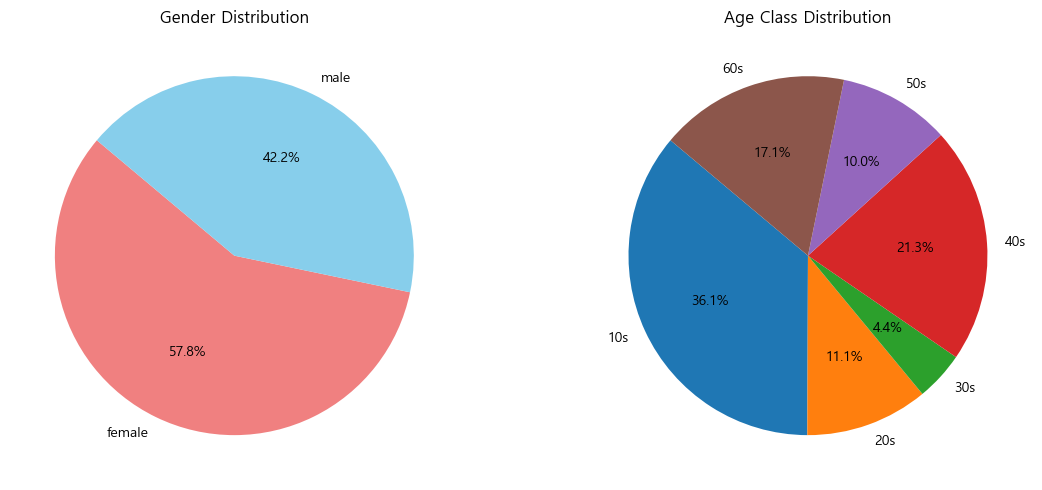

In [3]:
plt.figure(figsize=(12, 5))

# 성별 파이차트
plt.subplot(1, 2, 1)
gender_counts = df['sex'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=["lightcoral", "skyblue"])
plt.title("Gender Distribution")

# 연령대 파이차트
plt.subplot(1, 2, 2)
age_counts = df['age_class'].value_counts().reindex(['10s','20s','30s','40s','50s','60s'])
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Age Class Distribution")

plt.tight_layout()
plt.show()

## 1.4. Re-structure for YOLOv8 Classification  
> YOLOv8-cls 사용  
> labels.csv와 cropped_faces/를 기반으로 train/val 디렉토리 내부에 클래스별 폴더를 생성하여 이미지를 복사  

In [ ]:
df=pd.read_csv("../../data/processed/01_processed_data/training/01_labels.csv")
df

,filename,sex,age_class
0,F0001_IND_D_18_-45_01.jpg,female,10s
1,F0001_IND_D_18_-45_02.jpg,female,10s
2,F0001_IND_D_18_-45_03.jpg,female,10s
3,F0001_IND_D_18_-45_04.jpg,female,10s
4,F0001_IND_D_18_-90_01.jpg,female,10s
...,...,...,...
54019,F0800_IND_GM_80_0_02.jpg,female,60s
54020,F0800_IND_GM_80_45_01.jpg,female,60s
54021,F0800_IND_GM_80_45_02.jpg,female,60s
54022,F0800_IND_GM_80_90_01.jpg,female,60s


In [4]:
# 성별 + 나이 클래스 조합 -> 클래스명으로
df["class_name"]=df["sex"]+"_"+df["age_class"]
df

,filename,sex,age_class,class_name
0,F0001_IND_D_18_-45_01.jpg,female,10s,female_10s
1,F0001_IND_D_18_-45_02.jpg,female,10s,female_10s
2,F0001_IND_D_18_-45_03.jpg,female,10s,female_10s
3,F0001_IND_D_18_-45_04.jpg,female,10s,female_10s
4,F0001_IND_D_18_-90_01.jpg,female,10s,female_10s
...,...,...,...,...
54019,F0800_IND_GM_80_0_02.jpg,female,60s,female_60s
54020,F0800_IND_GM_80_45_01.jpg,female,60s,female_60s
54021,F0800_IND_GM_80_45_02.jpg,female,60s,female_60s
54022,F0800_IND_GM_80_90_01.jpg,female,60s,female_60s


In [ ]:
# 클래스명 -> 고유 인덱스 매핑
class_names=sorted(df["class_name"].unique())
class_to_idx={name: idx for idx, name in enumerate(class_names)}
print(f"클래스 인덱스 매핑: {class_to_idx}")

클래스 인덱스 매핑: {'female_10s': 0, 'female_20s': 1, 'female_30s': 2, 'female_40s': 3, 'female_50s': 4, 'female_60s': 5, 'male_10s': 6, 'male_20s': 7, 'male_30s': 8, 'male_40s': 9, 'male_50s': 10, 'male_60s': 11}


In [10]:
for name, idx in class_to_idx.items():
    print(f"{idx}: {name}")

0: female_10s
1: female_20s
2: female_30s
3: female_40s
4: female_50s
5: female_60s
6: male_10s
7: male_20s
8: male_30s
9: male_40s
10: male_50s
11: male_60s


In [ ]:
BASE_DIR = "../../data/processed/01_processed_data/training/YOLO_cls_dataset"
IMG_DIR = "../../data/processed/01_processed_data/training/cropped_faces"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

In [7]:
# stratify를 위해 class_name 컬럼 기준으로 분리
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42,
                                    stratify=df["class_name"])  # stratify: 미적용시 클래스가 valid에 할당되지 않음
                                                                # 즉 클래스 분포에는 test_size 비율이 적용안됨
                                                                # -> train단계에서 특정 클래스에 대해 학습해도 valid 단게에서 검증 불가
                                                                # 따라서 stratify을 사용해야 클래스 분포 비율까지 맞춰 줌  

In [8]:
# 이미지 복사 함수
def copy_images(split_df, mode_dir):
    for _, row in tqdm(split_df.iterrows(), total=len(split_df)):
        src_img_path = os.path.join(IMG_DIR, row["filename"])
        class_folder = str(class_to_idx[row["class_name"]])
        dest_folder = os.path.join(mode_dir, class_folder)
        os.makedirs(dest_folder, exist_ok=True)

        dst_img_path = os.path.join(dest_folder, row["filename"])
        shutil.copy2(src_img_path, dst_img_path)

In [9]:
copy_images(train_df, TRAIN_DIR)
copy_images(val_df, VAL_DIR)
print("YOLOv8 classification 구조로 변환 완료")

100%|██████████| 10805/10805 [02:02<00:00, 88.46it/s] 

YOLOv8 classification 구조로 변환 완료


# 2. Model Training
> YOLOv8-cls: 분류 전용 사전학습 모델

in colab.  

# 3. VAL DATA Pre-Processing

## 3.1. Resize IMG & Make csv file with labeling 

In [ ]:
# 경로 설정
ZIP_IMG_PATH = "../../data/raw/validation/image_data/V_image_data.zip"
ZIP_LABEL_PATH = "../../data/raw/validation/labeling_data/V_labeling_data.zip"
OUTPUT_DIR = "../../data/processed/01_processed_data/validation/resized_faces"
CSV_PATH = "../../data/processed/01_processed_data/validation/val_labels.csv"

In [14]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [15]:
# 성별 mapping
sex_Male_list = ['GF', 'F', 'S', 'S1', 'S2', 'S3', 'S4']
sex_Female_list = ['GM', 'M', 'D', 'D1', 'D2', 'D3', 'D4']

In [16]:
# ZIP 파일 열기
img_zip = zipfile.ZipFile(ZIP_IMG_PATH, "r")
json_zip = zipfile.ZipFile(ZIP_LABEL_PATH, "r")
img_names = [name for name in img_zip.namelist() if name.endswith(".JPG") or name.endswith(".jpg")]

In [17]:
# CSV 파일 저장용
csv_rows = []

In [18]:
for img_name in tqdm(img_names):
    base_name = os.path.basename(img_name).split(".")[0]
    json_name = base_name + ".json"

    try:
        # 이미지 파일 로드
        img_data = img_zip.read(img_name)
        img = Image.open(io.BytesIO(img_data)).convert("RGB")

        # JSON 파일 로드
        json_data = json.load(io.TextIOWrapper(json_zip.open(json_name), encoding="utf-8"))
        member = json_data["member"][0]

        # 성별
        personal_sex = member["personal_id"].upper()
        if personal_sex in sex_Male_list:
            sex = "male"
        elif personal_sex in sex_Female_list:
            sex = "female"
        else:
            continue

        # 나이 클래스
        age = int(member["age"])
        if age < 20:
            age_class = "10s"
        elif age < 30:
            age_class = "20s"
        elif age < 40:
            age_class = "30s"
        elif age < 50:
            age_class = "40s"
        elif age < 60:
            age_class = "50s"
        else:
            age_class = "60s"

        # resize만 수행
        resized = img.resize((224, 224))
        save_name = base_name + ".jpg"
        resized.save(os.path.join(OUTPUT_DIR, save_name))

        # CSV 라벨 기록
        csv_rows.append({"filename": save_name, "sex": sex, "age_class": age_class})

    except Exception as e:
        print(f"{img_name}에서 에러 발생: {e}")
        continue

# CSV 저장
df = pd.DataFrame(csv_rows)
df.to_csv(CSV_PATH, index=False)

100%|██████████| 3200/3200 [05:50<00:00,  9.12it/s]


## 3.2. EDA

In [ ]:
val_df=pd.read_csv("../../data/processed/01_processed_data/validation/val_labels.csv")
print(val_df['sex'].value_counts(),"\n")
print(val_df['age_class'].value_counts())
display(val_df.head(2))
display(val_df.tail(2))

sex
female    1690
male      1510
Name: count, dtype: int64 

age_class
10s    1250
40s     600
20s     440
50s     430
30s     290
60s     190
Name: count, dtype: int64


,filename,sex,age_class
0,F0801_IND_F_48_-45_01.jpg,male,40s
1,F0801_IND_F_48_-45_02.jpg,male,40s


,filename,sex,age_class
3198,F0900_IND_M_57_90_01.jpg,female,50s
3199,F0900_IND_M_57_90_02.jpg,female,50s


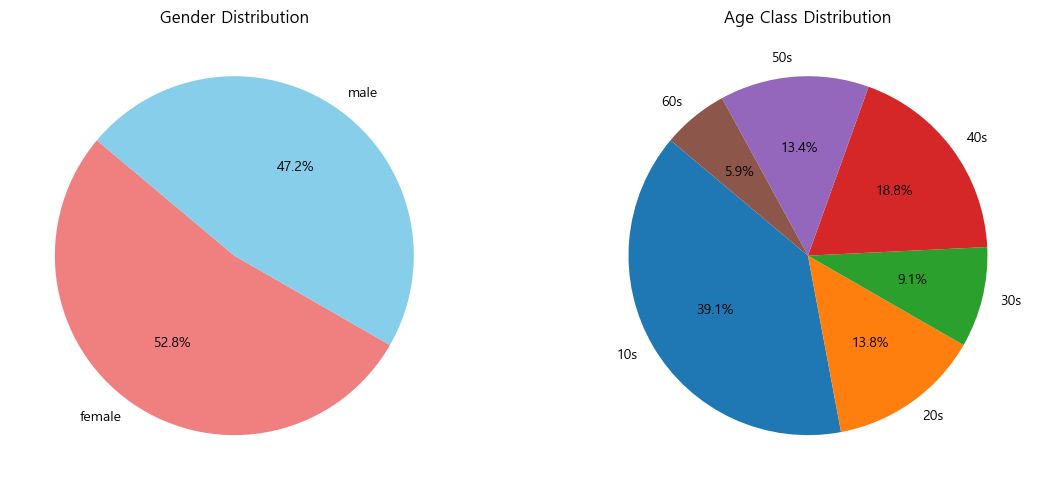

In [5]:
plt.figure(figsize=(12, 5))

# 성별 파이차트
plt.subplot(1, 2, 1)
gender_counts = val_df['sex'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=["lightcoral", "skyblue"])
plt.title("Gender Distribution")

# 연령대 파이차트
plt.subplot(1, 2, 2)
age_counts = val_df['age_class'].value_counts().reindex(['10s','20s','30s','40s','50s','60s'])
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Age Class Distribution")

plt.tight_layout()
plt.show()